# Task 1

---

## Web scraping and analysis

This Jupyter notebook includes some code to get you started with web scraping. We will use a package called `BeautifulSoup` to collect the data from the web. Once you've collected your data and saved it into a local `.csv` file you should start with your analysis.

### Scraping data from Skytrax

If you visit [https://www.airlinequality.com] you can see that there is a lot of data there. For this task, we are only interested in reviews related to British Airways and the Airline itself.

If you navigate to this link: [https://www.airlinequality.com/airline-reviews/british-airways] you will see this data. Now, we can use `Python` and `BeautifulSoup` to collect all the links to the reviews and then to collect the text data on each of the individual review links.

In [208]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [209]:
base_url = "https://www.airlinequality.com/airline-reviews/british-airways"
pages = 10
page_size = 100

reviews = []

# for i in range(1, pages + 1):
for i in range(1, pages + 1):

    print(f"Scraping page {i}")

    # Create URL to collect links from paginated data
    url = f"{base_url}/page/{i}/?sortby=post_date%3ADesc&pagesize={page_size}"

    # Collect HTML data from this page
    response = requests.get(url)

    # Parse content
    content = response.content
    parsed_content = BeautifulSoup(content, 'html.parser')
    for para in parsed_content.find_all("div", {"class": "text_content"}):
        reviews.append(para.get_text())
    
    print(f"   ---> {len(reviews)} total reviews")

Scraping page 1
   ---> 100 total reviews
Scraping page 2
   ---> 200 total reviews
Scraping page 3
   ---> 300 total reviews
Scraping page 4
   ---> 400 total reviews
Scraping page 5
   ---> 500 total reviews
Scraping page 6
   ---> 600 total reviews
Scraping page 7
   ---> 700 total reviews
Scraping page 8
   ---> 800 total reviews
Scraping page 9
   ---> 900 total reviews
Scraping page 10
   ---> 1000 total reviews


In [210]:
df = pd.DataFrame()
df["reviews"] = reviews
df.head()


,reviews
0,✅ Trip Verified | Flight cancelled with no rea...
1,✅ Trip Verified | This is a route I fly regula...
2,✅ Trip Verified | While BA may have made some...
3,✅ Trip Verified | British Airways new Club Sui...
4,"✅ Trip Verified | Four very pleasant, on time..."


Removing Unnecessary text patterns

In [211]:
def get_delimiter(input: list) -> int:
    try:
        return input.index('|')
    except ValueError:
        return 0


In [212]:
df['reviews_clean'] = df['reviews'].apply(lambda x: x[get_delimiter(x) + 1 :])

### Using CountVectorizer, TfidfVectorizer for EDA

In [213]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

cv = CountVectorizer(lowercase=True, stop_words='english')
reviews_t = cv.fit_transform(df['reviews_clean'])

In [214]:
word_counts = reviews_t.toarray().sum(axis=0)
vocabulary = cv.vocabulary_

unique_words = {word: word_counts[i] for word, i in vocabulary.items()}

In [215]:
df_cv = pd.DataFrame(dict(word = list(unique_words.keys()), counts = list(unique_words.values())))
df_cv.sort_values(by='counts', ascending= False).head(10)

,word,counts
0,flight,1987
78,ba,1300
30,service,737
48,time,550
505,london,514
162,seat,458
72,crew,450
35,class,450
142,british,435
103,food,431


#### Most Frequently occuring N-grams
An n-gram is a sequence of n words in a text. 
For this EDA, we will be using Bi-gram. <br>
<em> Ex. 'Great Flight', 'Bad Weather', etc. </em>

In [216]:
cv_bigram = CountVectorizer(lowercase=True, stop_words='english', ngram_range=(2,2))
reviews_t = cv_bigram.fit_transform(df['reviews_clean'])

In [217]:
word_counts = reviews_t.toarray().sum(axis=0)
vocabulary = cv_bigram.vocabulary_

unique_words = {word: word_counts[i] for word, i in vocabulary.items()}
df_cv = pd.DataFrame(dict(word = list(unique_words.keys()), counts = list(unique_words.values())))
df_cv.sort_values(by='counts', ascending= False).head(10)

,word,counts
168,british airways,409
635,business class,318
31,customer service,200
76,cabin crew,181
910,london heathrow,89
334,return flight,89
1555,connecting flight,77
0,flight cancelled,65
702,premium economy,63
87,club world,61


Insights: <br>
As observed, using most frequent n-gram gave us a clearer insights in frequent word meanings. Top words relates to the airline itself, talks about business class, customer service/crews, types of flight, and the airport London Heathrow



### Using Term Frequency - Inverse Document Frequency for Factor Analysis

In [227]:
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(5, 1, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[-n_top_words:]
        top_features = feature_names[top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7, alpha = 0.5)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

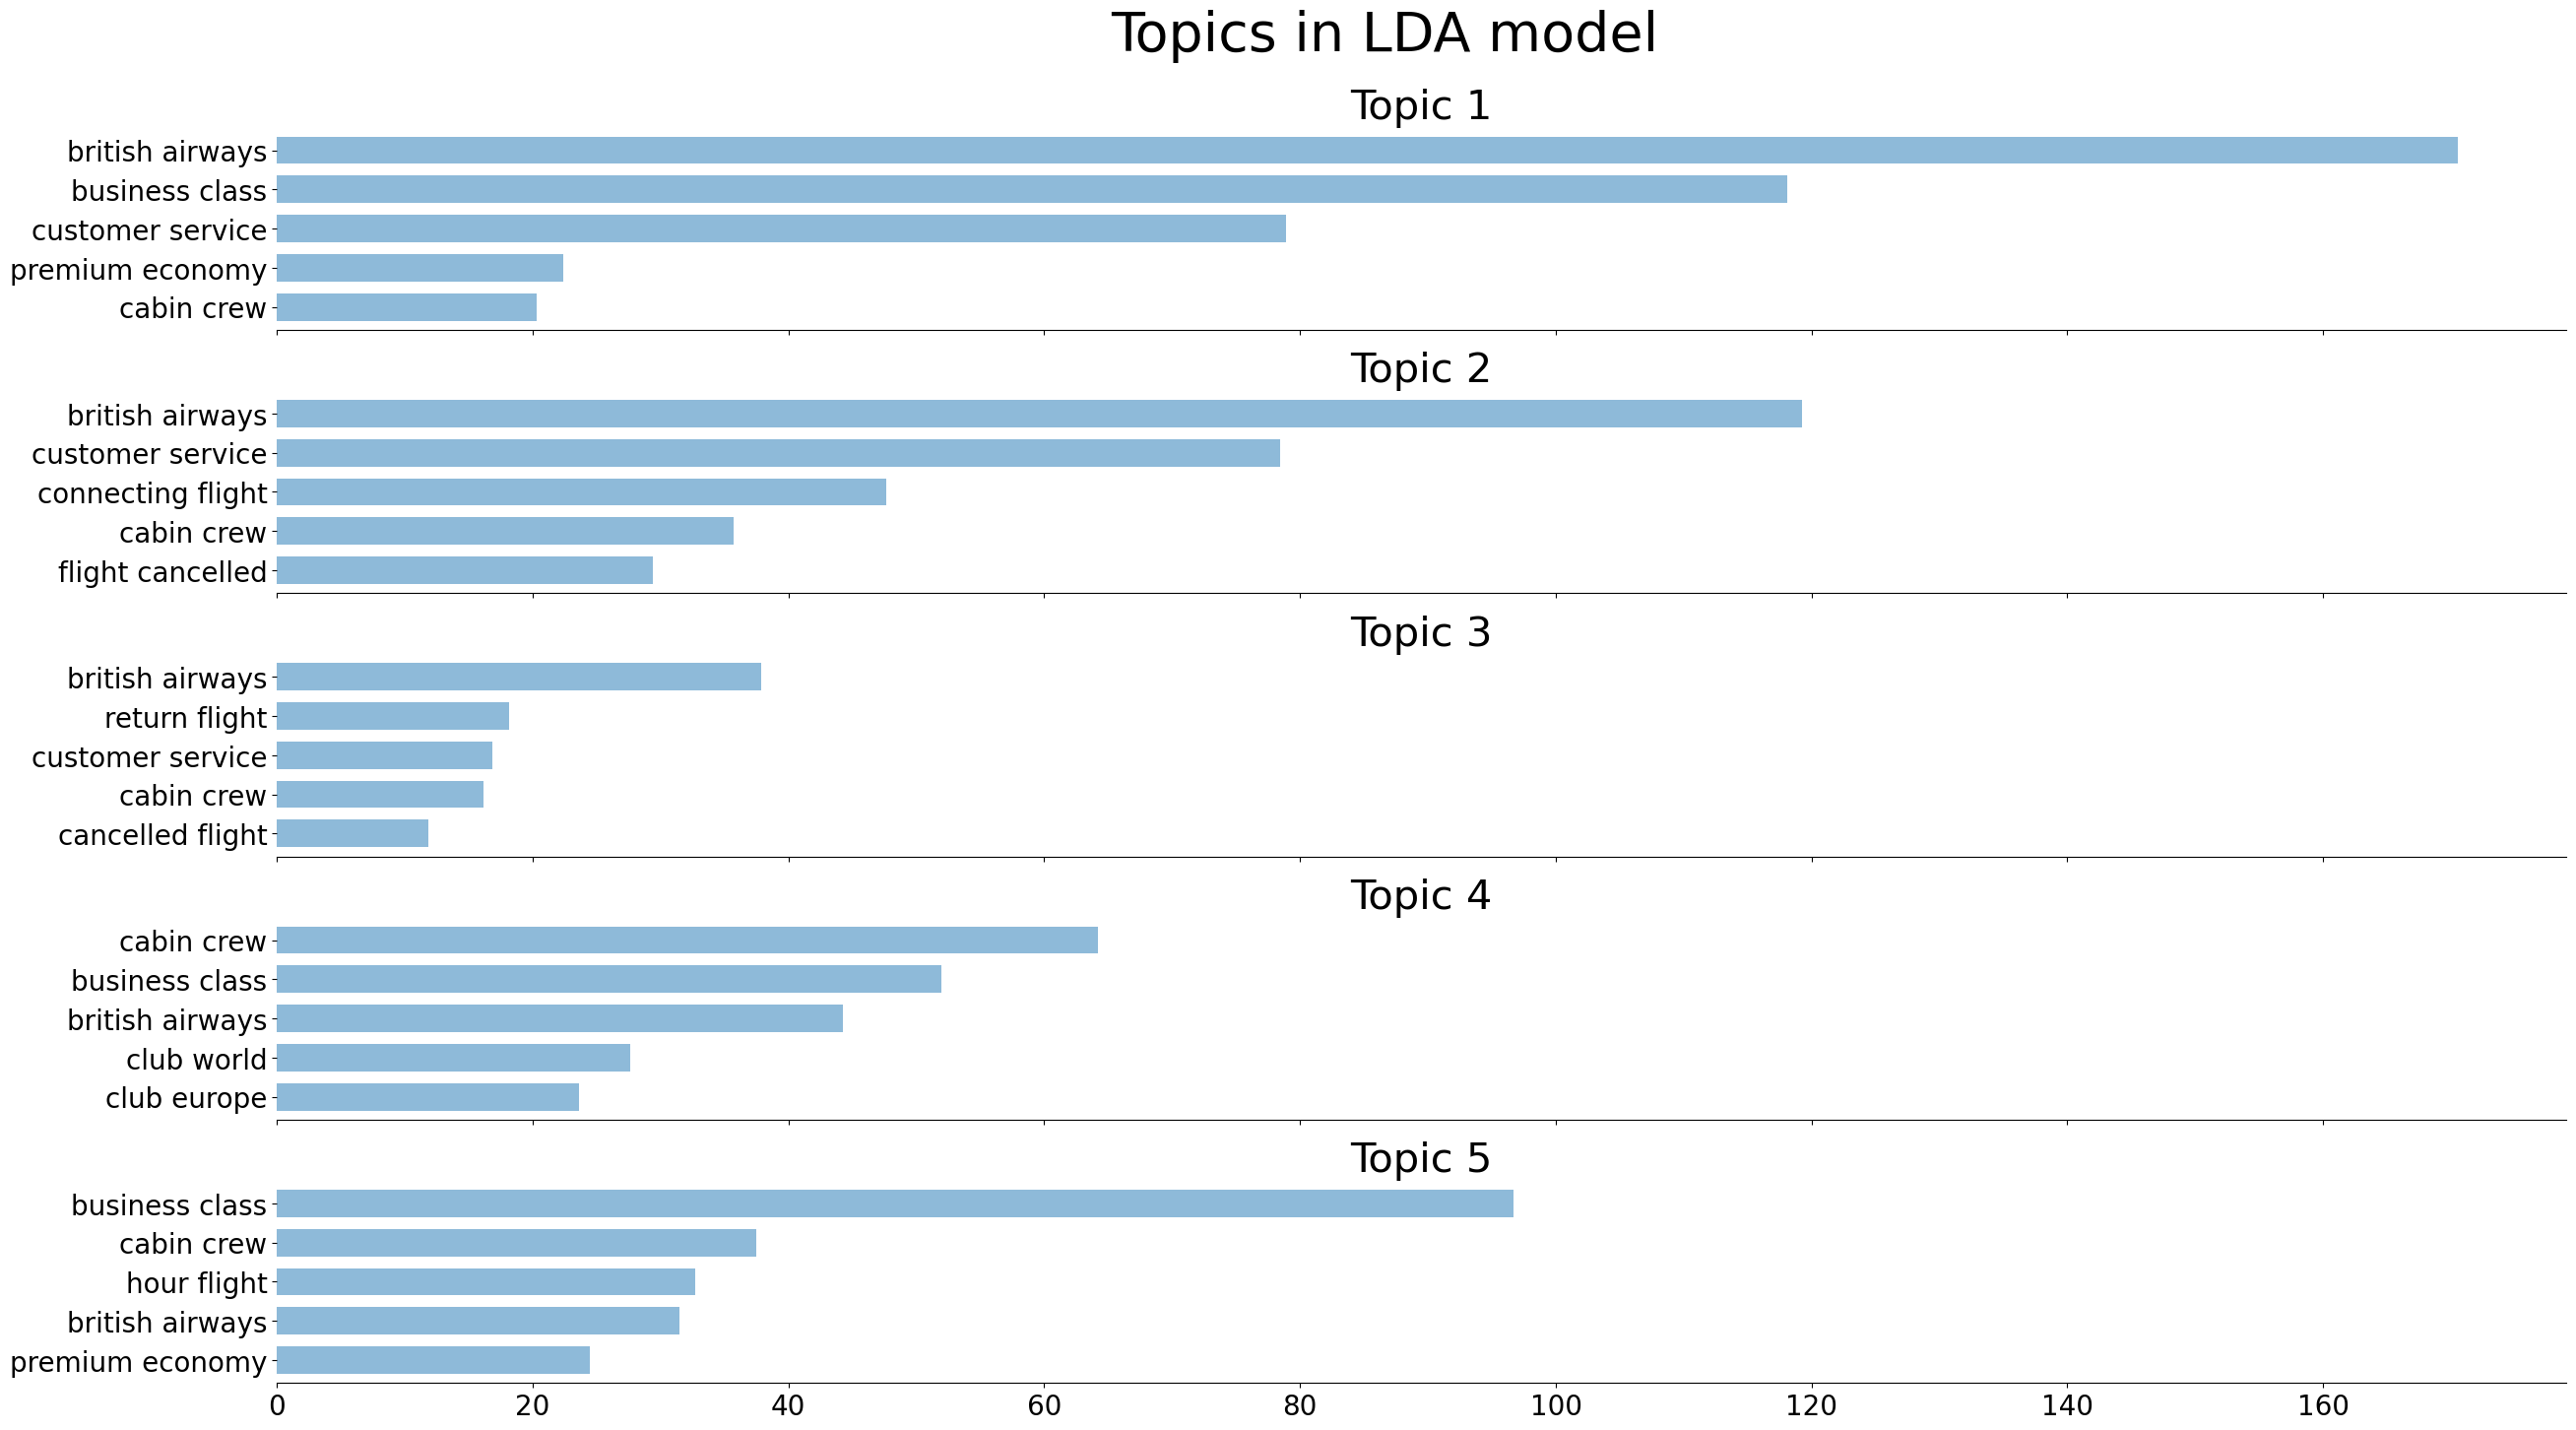

In [228]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components=5, max_iter = 5, learning_method='online', random_state=10)
lda.fit(reviews_t)
tf_feature_names = cv_bigram.get_feature_names_out()
plot_top_words(lda, tf_feature_names, n_top_words = 5 ,title = "Topics in LDA model")
